#### This code generates large dataframe containing multiple timeseries

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn import tree

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

import time
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve, auc

#### parameters to set

In [2]:
n_series = 6
n_timesteps = 8*24*3600 # 8 days

# regular behaviour
max_noise_amplitude = 0.05 # all the timeseries will have values between 0 and 1

# anomalies
p_anomaly = 10E-6
max_anomaly_duration = 4*3600 # 4 h

#### generate normal data

In [3]:
df = pd.DataFrame()
for s in range(n_series):
    v = np.random.normal(random.random()/2, max_noise_amplitude/random.randint(1, 8), n_timesteps) 
    df[s]=pd.Series(v)
df['Flag']=0
#df.head()

#### generate anomalies

In [4]:
to_generate = int(n_timesteps * p_anomaly)
for a in range(to_generate):
    affects = random.sample(range(n_series), random.randint(1, n_series))
    duration = int(max_anomaly_duration * random.random())
    start = (n_timesteps * random.random())
    end = min(start+duration, n_timesteps)
    for s in affects:
        df.loc[start:end,s] = df.loc[start:end,s] + random.random() * 0.3
    if len(affects)>1:
        df.loc[start:end,"Flag"]=1
        

#### enforce range

In [5]:
df[df<0] = 0
df[df>1] = 1

#### plot timeseries

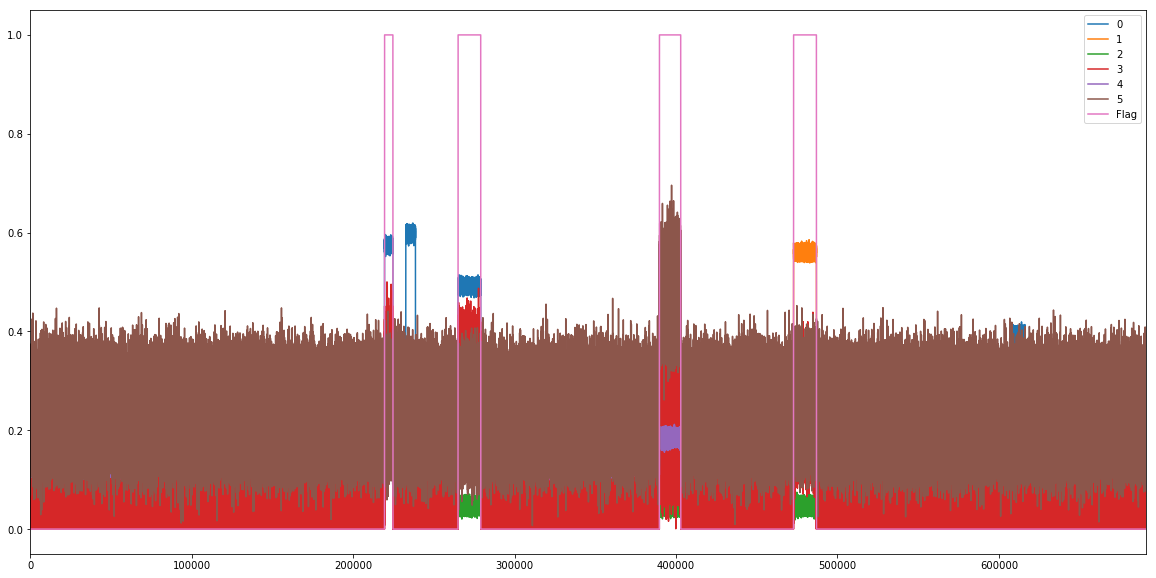

In [6]:
df.plot(figsize=(20,10))
#print df[147599]

#### running BDT

In [7]:
start_time = time.clock()

predicted_flag_array = np.zeros((24*3600), dtype=np.int)
auc_score_array = np.zeros((24*3600), dtype=np.float)
score_holder_array = np.zeros(3600, dtype=np.float)
anomaly_array = np.ones(3600, dtype=np.int)
not_anomaly_array = np.zeros(3600, dtype=np.int)

#### Train a model for all hours after the first day

In [8]:
#separate data into Reference and Subject
def trainer(reference, subject):
    
    reference.loc[:].Flag = 0 # Flagging the reference data as 0
    X_ref = reference.loc[:, range(n_series)] #refers to the feature set data
    y_ref = reference.Flag #refers to the label data
    
    subject.loc[:].Flag = 1 # Flagging the subject data as 1
    X_sub = subject.loc[:, range(n_series)] #refers to the feature set data
    y_sub = subject.Flag #refers to the label data

    #separate Reference into Train and Test
    X_ref_train, X_ref_test, y_ref_train, y_ref_test = train_test_split(X_ref, y_ref, test_size = 0.3, random_state=50)
    #separate Subject into Train and Test
    X_sub_train, X_sub_test, y_sub_train, y_sub_test = train_test_split(X_sub, y_sub, test_size = 0.3, random_state=50)

    #Combine reference and subject train datasets
    X_train_frames = [X_ref_train, X_sub_train] 
    X_train = pd.concat(X_train_frames, ignore_index=True) #combine the 70% training data features from both reference and subject
    
    y_train_frames = [y_ref_train, y_sub_train]
    y_train = pd.concat(y_train_frames, ignore_index=True) #combine the 70% training data label from both reference and subject

    #Combine reference and subject test datasets
    X_test_frames = [X_ref_test, X_sub_test]
    X_test = pd.concat(X_test_frames, ignore_index=True) #combine the 30% training data features from both reference and subject
    
    y_test_frames = [y_ref_test, y_sub_test]
    y_test = pd.concat(y_test_frames, ignore_index=True) #combine the 30% training data label from both reference and subject

    #Train model using the combined train data
    clf = AdaBoostClassifier(n_estimators=50)
    clf.fit(X_train, y_train) 
    #train an AdaBoost model to be able to tell the difference between the reference and subject data

    #Predict using the combined test data
    y_predict = clf.predict(X_test)
    #use the trained AdaBoost model on the testing data. This is the predicted result
        
    fpr, tpr, thresholds = roc_curve(y_test, y_predict) # calculate the false positive rate and true positive rate
    auc_score = auc(fpr, tpr) #calculate the AUC score
    
    #plt.plot(fpr,tpr)
    #plt.show()
    
    score_holder_array.fill(auc_score)
    print ("auc_score = ", auc_score) #finds the auc score. If auc~.5, then no anomalies. If auc>0.5, then there are anomalies
    print ("feature importance = ", clf.feature_importances_)
    
    return [clf, auc_score, fpr, tpr]

In [ ]:
def rankImportance(clf):
    f = 0
    importances = clf.feature_importances_
    indices = np.argsort(importances)[::-1]
    print("Feature ranking:")
    while f < 6:
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
        f = f + 1

#### Calculate AUC

n =  86400
auc_score =  0.5
feature importance =  [ 0.2   0.22  0.16  0.22  0.1   0.1 ]


/home/ivukotic/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


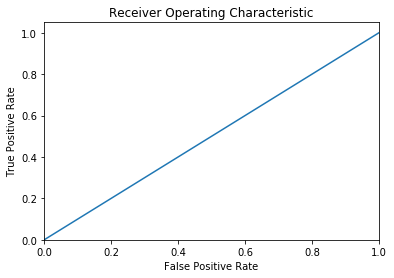

n =  90000
auc_score =  0.5
feature importance =  [ 0.08  0.24  0.16  0.18  0.14  0.2 ]


/home/ivukotic/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


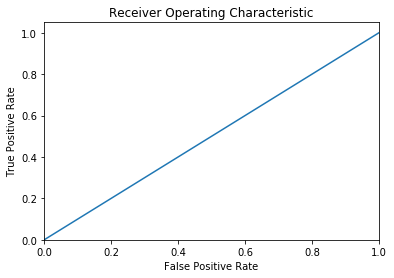

n =  93600
auc_score =  0.499980709877
feature importance =  [ 0.14  0.16  0.2   0.14  0.18  0.18]


/home/ivukotic/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


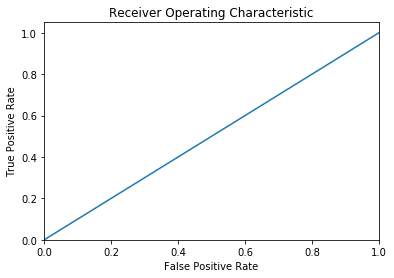

n =  97200
auc_score =  0.5
feature importance =  [ 0.24  0.14  0.24  0.14  0.14  0.1 ]


/home/ivukotic/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


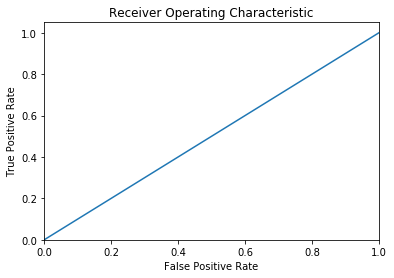

n =  100800
auc_score =  0.5
feature importance =  [ 0.14  0.14  0.16  0.08  0.28  0.2 ]


/home/ivukotic/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


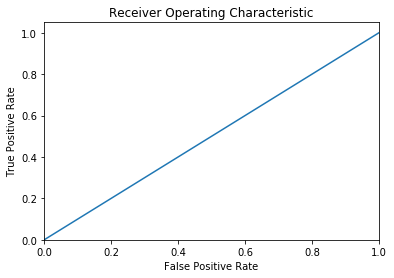

n =  104400
auc_score =  0.499980709877
feature importance =  [ 0.12  0.12  0.32  0.1   0.18  0.16]


/home/ivukotic/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


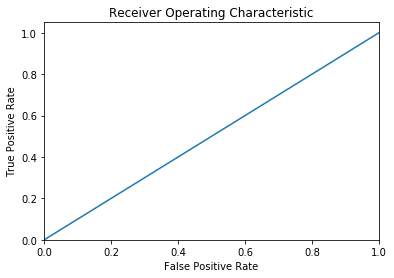

n =  108000
auc_score =  0.499980709877
feature importance =  [ 0.22  0.12  0.18  0.1   0.24  0.14]


/home/ivukotic/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


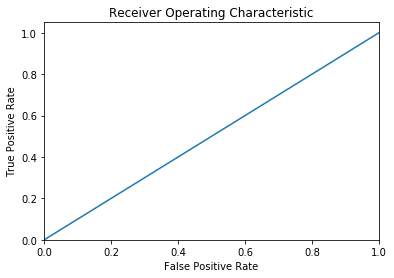

n =  111600
auc_score =  0.5
feature importance =  [ 0.24  0.14  0.24  0.08  0.14  0.16]


/home/ivukotic/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


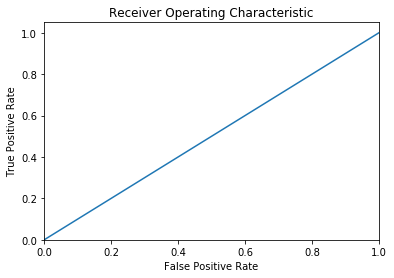

n =  115200
auc_score =  0.499980709877
feature importance =  [ 0.14  0.16  0.14  0.18  0.16  0.22]


/home/ivukotic/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


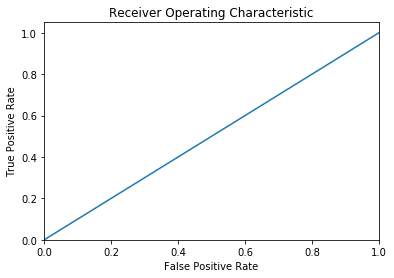

n =  118800
auc_score =  0.499980709877
feature importance =  [ 0.12  0.2   0.2   0.04  0.16  0.28]


/home/ivukotic/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


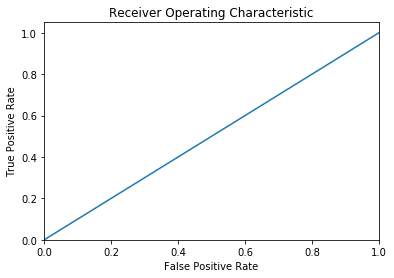

n =  122400
auc_score =  0.499980709877
feature importance =  [ 0.26  0.18  0.1   0.1   0.12  0.24]


/home/ivukotic/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


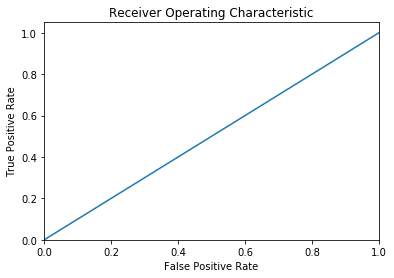

n =  126000
auc_score =  0.499980709877
feature importance =  [ 0.08  0.24  0.16  0.18  0.14  0.2 ]


/home/ivukotic/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


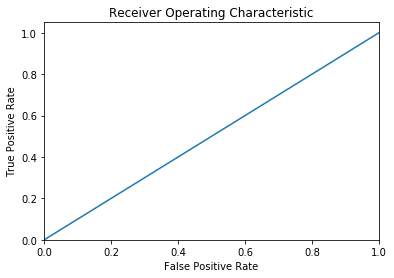

n =  129600
auc_score =  0.5
feature importance =  [ 0.2   0.02  0.26  0.04  0.2   0.28]


/home/ivukotic/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


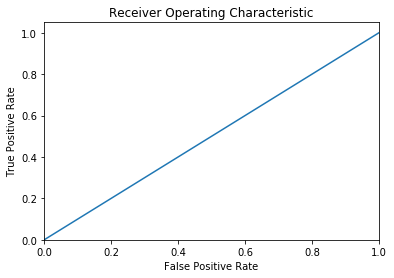

n =  133200
auc_score =  0.5
feature importance =  [ 0.08  0.34  0.16  0.14  0.08  0.2 ]


/home/ivukotic/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


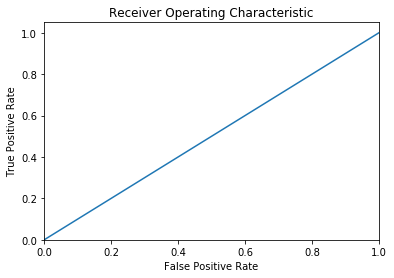

n =  136800
auc_score =  0.499961419753
feature importance =  [ 0.08  0.2   0.26  0.08  0.12  0.26]


/home/ivukotic/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


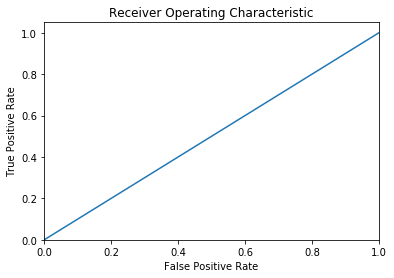

n =  140400
auc_score =  0.500424382716
feature importance =  [ 0.18  0.1   0.08  0.14  0.14  0.36]


/home/ivukotic/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


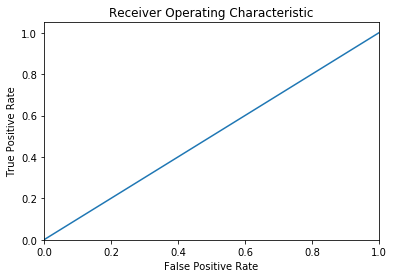

n =  144000
auc_score =  0.49994212963
feature importance =  [ 0.1   0.18  0.14  0.24  0.24  0.1 ]


/home/ivukotic/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


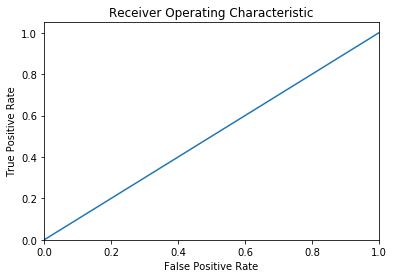

n =  147600
auc_score =  0.499980709877
feature importance =  [ 0.16  0.1   0.04  0.12  0.34  0.24]


/home/ivukotic/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


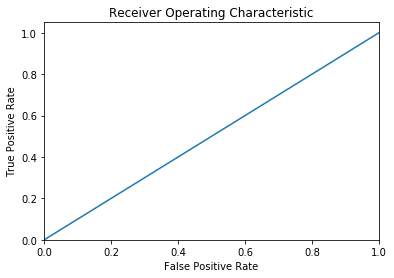

n =  151200
auc_score =  0.5
feature importance =  [ 0.22  0.24  0.2   0.2   0.14  0.  ]


/home/ivukotic/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


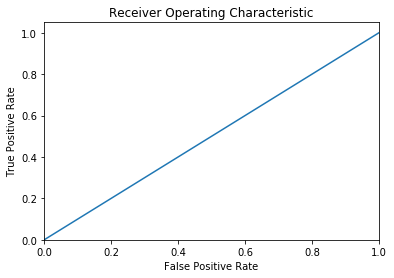

n =  154800
auc_score =  0.49994212963
feature importance =  [ 0.1   0.16  0.18  0.18  0.26  0.12]


/home/ivukotic/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


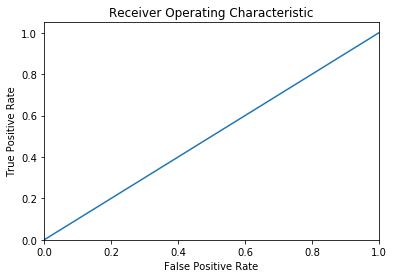

n =  158400
auc_score =  0.49994212963
feature importance =  [ 0.16  0.16  0.28  0.12  0.12  0.16]


/home/ivukotic/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


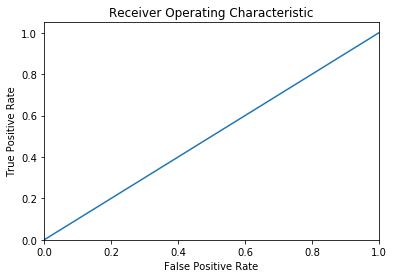

n =  162000
auc_score =  0.5
feature importance =  [ 0.2   0.24  0.12  0.18  0.14  0.12]


/home/ivukotic/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


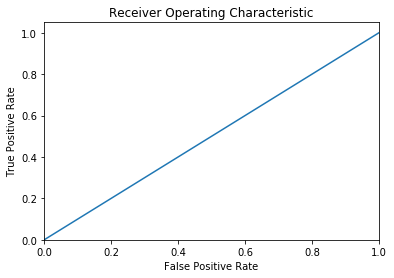

n =  165600
auc_score =  0.5
feature importance =  [ 0.18  0.2   0.16  0.2   0.16  0.1 ]


/home/ivukotic/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


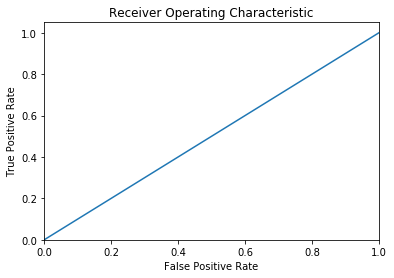

n =  169200
auc_score =  0.5
feature importance =  [ 0.12  0.32  0.04  0.18  0.22  0.12]


/home/ivukotic/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


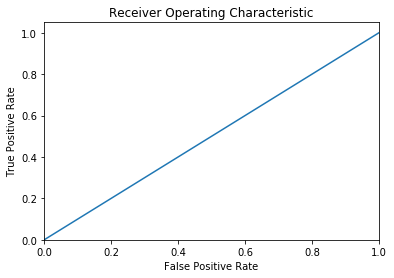

n =  172800
auc_score =  0.499980709877
feature importance =  [ 0.22  0.28  0.24  0.06  0.08  0.12]


/home/ivukotic/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


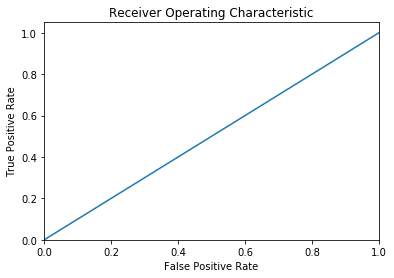

n =  176400
auc_score =  0.499961419753
feature importance =  [ 0.18  0.12  0.22  0.12  0.18  0.18]


/home/ivukotic/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


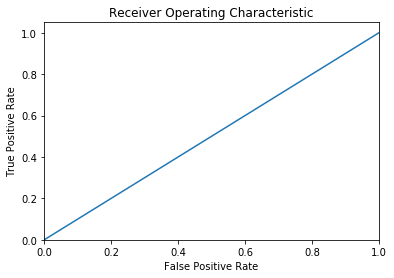

n =  180000
auc_score =  0.499922839506
feature importance =  [ 0.1   0.22  0.18  0.14  0.18  0.18]


/home/ivukotic/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


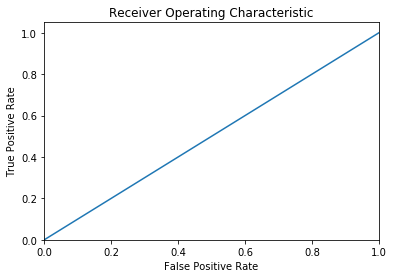

n =  183600
auc_score =  0.499980709877
feature importance =  [ 0.08  0.16  0.24  0.06  0.16  0.3 ]


/home/ivukotic/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


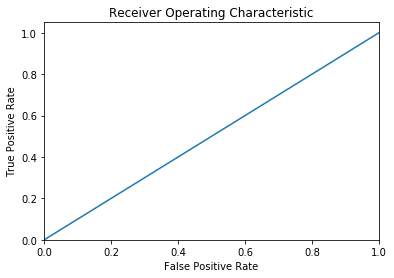

n =  187200
auc_score =  0.499961419753
feature importance =  [ 0.2   0.16  0.24  0.1   0.12  0.18]


/home/ivukotic/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


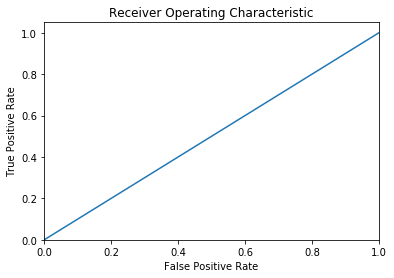

n =  190800
auc_score =  0.5
feature importance =  [ 0.1   0.22  0.08  0.14  0.26  0.2 ]


/home/ivukotic/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


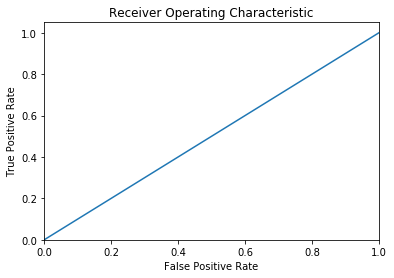

n =  194400
auc_score =  0.499980709877
feature importance =  [ 0.1   0.12  0.3   0.2   0.14  0.14]


/home/ivukotic/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


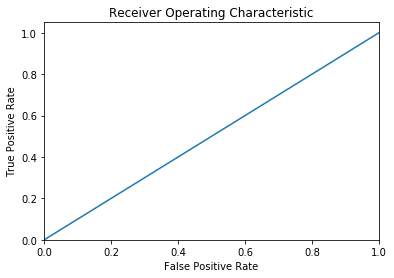

n =  198000
auc_score =  0.5
feature importance =  [ 0.14  0.16  0.18  0.16  0.2   0.16]


/home/ivukotic/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


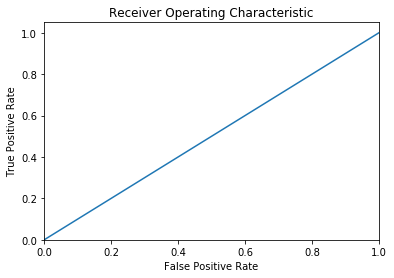

n =  201600


In [ ]:
n = 24*3600 # number of seconds in the first day
m = 0
hour = 3600
k = 0



while(n <= n_timesteps):
    print("n = ", n)
    
    k = k + 1
    ref = df[m:n] #reference data refers to the data collected from the first day
    ref_reset_index = ref.reset_index(drop=True)
    
    sub = df[n:n+hour] #subject data refers to the data collected from the last hour
    sub_reset_index = sub.reset_index(drop=True)
    
    clf, auc_score, fpr1, tpr1 = trainer(ref_reset_index, sub_reset_index)
    
#     plt.title('Receiver Operating Characteristic')
#     plt.plot(fpr1,tpr1)
#     plt.legend(loc = 'lower right')
#     plt.xlim([0, 1])
#     plt.ylim([0, 1.05])
#     plt.ylabel('True Positive Rate')
#     plt.xlabel('False Positive Rate')
#     plt.show()
    
    # detect and record anormaly                
    if(auc_score >= 0.55):
        predicted_flag_array = np.append(predicted_flag_array, anomaly_array)
        rankImportance(clf)
        
        plt.title('Receiver Operating Characteristic')
        plt.plot(fpr1,tpr1)
        plt.legend(loc = 'lower right')
        plt.xlim([0, 1])
        plt.ylim([0, 1.05])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()
        
    else:
        predicted_flag_array = np.append(predicted_flag_array, not_anomaly_array)
    
    auc_score_array = np.append(auc_score_array, score_holder_array)
        
    m = m + hour
    n = n + hour

In [ ]:
#print("--- %s seconds ---" % (time.time() - start_time))

y_predict_df = pd.DataFrame(predicted_flag_array[0:n_timesteps], columns=['Predict_Flag']) #label my predicted anomalies

x_y_combined = pd.concat([df, y_predict_df], axis=1) #append the column to the right of the original table
x_y_combined.plot(style=['-', '-', '-', '-', '-', '-', '-', '--'], figsize=(20,10))

In [ ]:
y_predict_df.plot(style=['--'], figsize=(20,10))

In [ ]:
half_array = np.zeros(n_timesteps, dtype=np.float)
half_array.fill(0.5)
#print half_array
half_df = pd.DataFrame(half_array[0:n_timesteps], columns=['AUC = 0.5'])

upper_threshold_array = np.zeros(n_timesteps, dtype=np.float)
upper_threshold_array.fill(0.55)
upper_threshold_df = pd.DataFrame(upper_threshold_array[0:n_timesteps], columns=['Upperthreshold = 0.55'])

auc_score_df = pd.DataFrame(auc_score_array[0:n_timesteps], columns=['AUC Score'])

tuner = pd.concat([y_predict_df, auc_score_df], axis=1)
tuner2 = pd.concat([tuner, half_df], axis=1)
tuner3 = pd.concat([tuner2, upper_threshold_df], axis=1)
tuner3.plot(style=['--', '-', '-', '-'], figsize=(20,10))

In [ ]:
upper_threshold_array = np.zeros(n_timesteps, dtype=np.float)
upper_threshold_array.fill(0.55)
upper_threshold_df = pd.DataFrame(upper_threshold_array[0:n_timesteps], columns=['Upperthreshold = 0.55'])

auc_score_df = pd.DataFrame(auc_score_array[0:n_timesteps], columns=['AUC Score'])

tuner = pd.concat([y_predict_df, auc_score_df], axis=1)
tuner2 = pd.concat([tuner, upper_threshold_df], axis=1)
tuner2.plot(style=['--', '-', '-'], figsize=(20,10))